<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Глубинное обучение, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 2: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

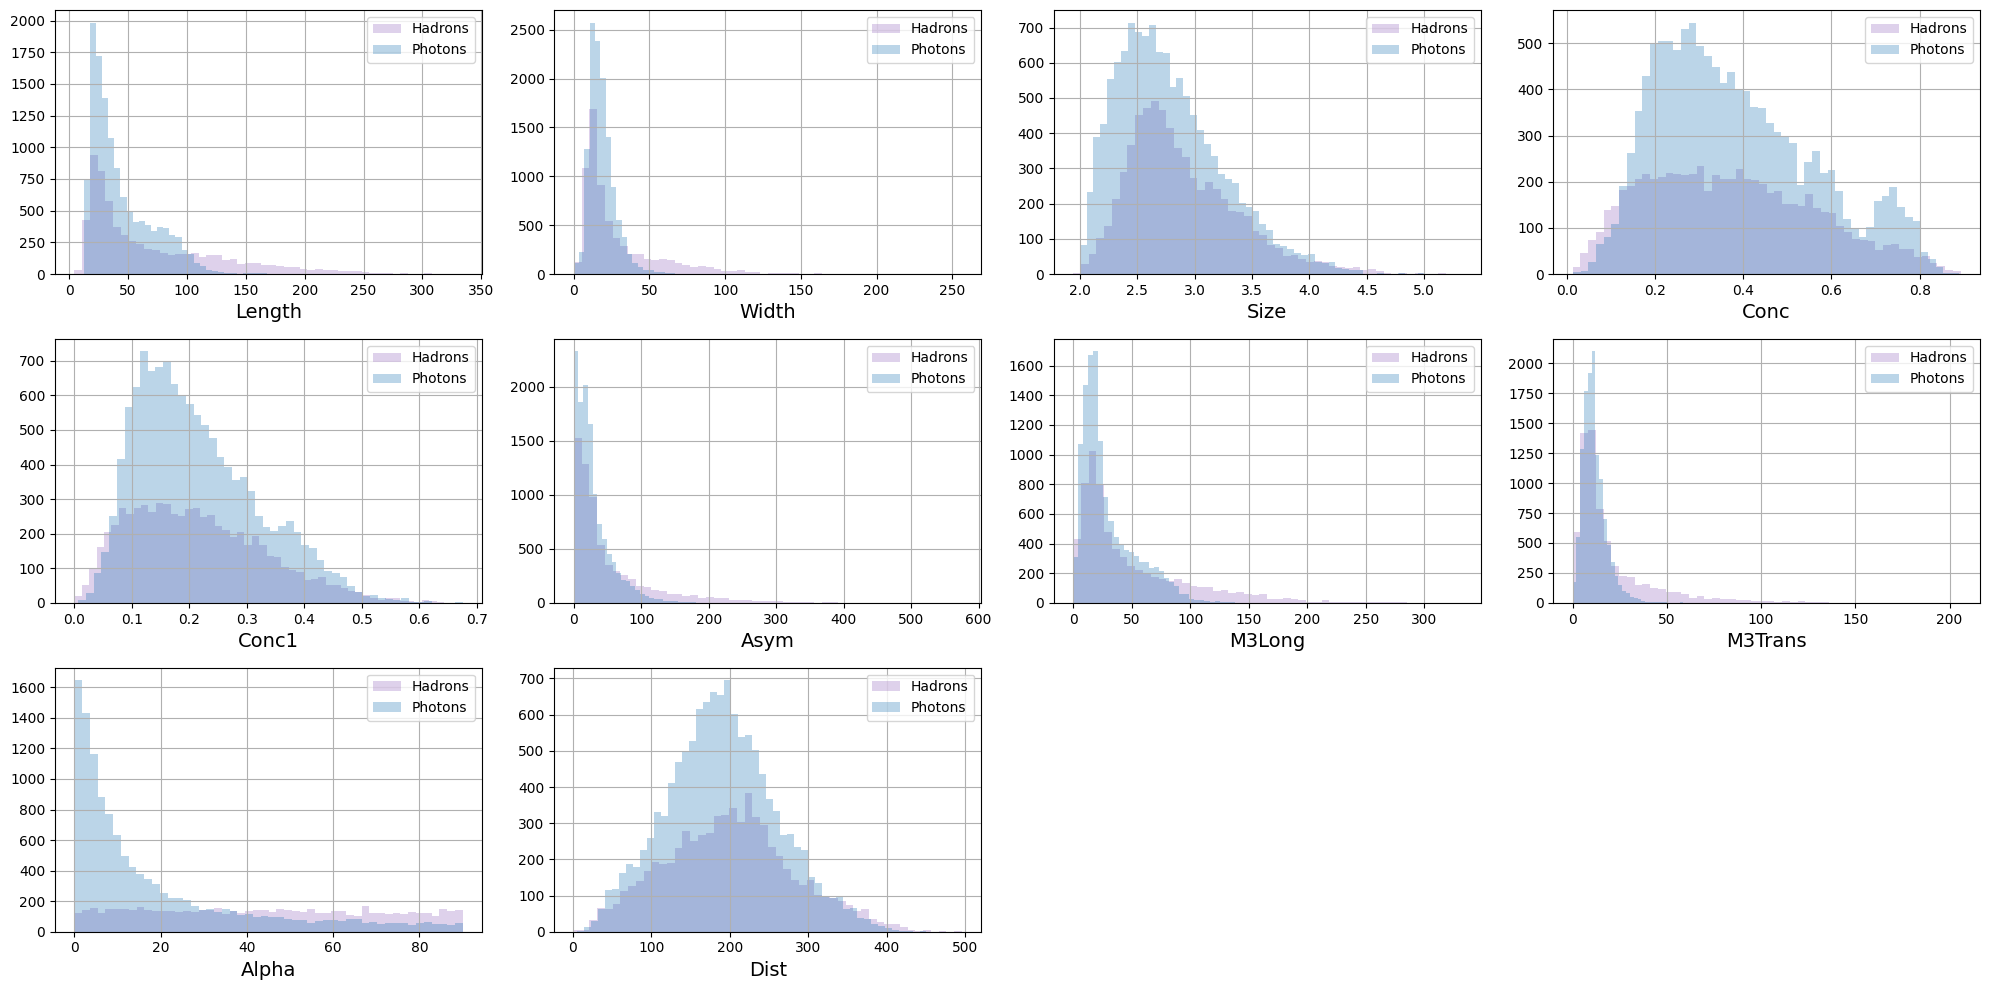

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

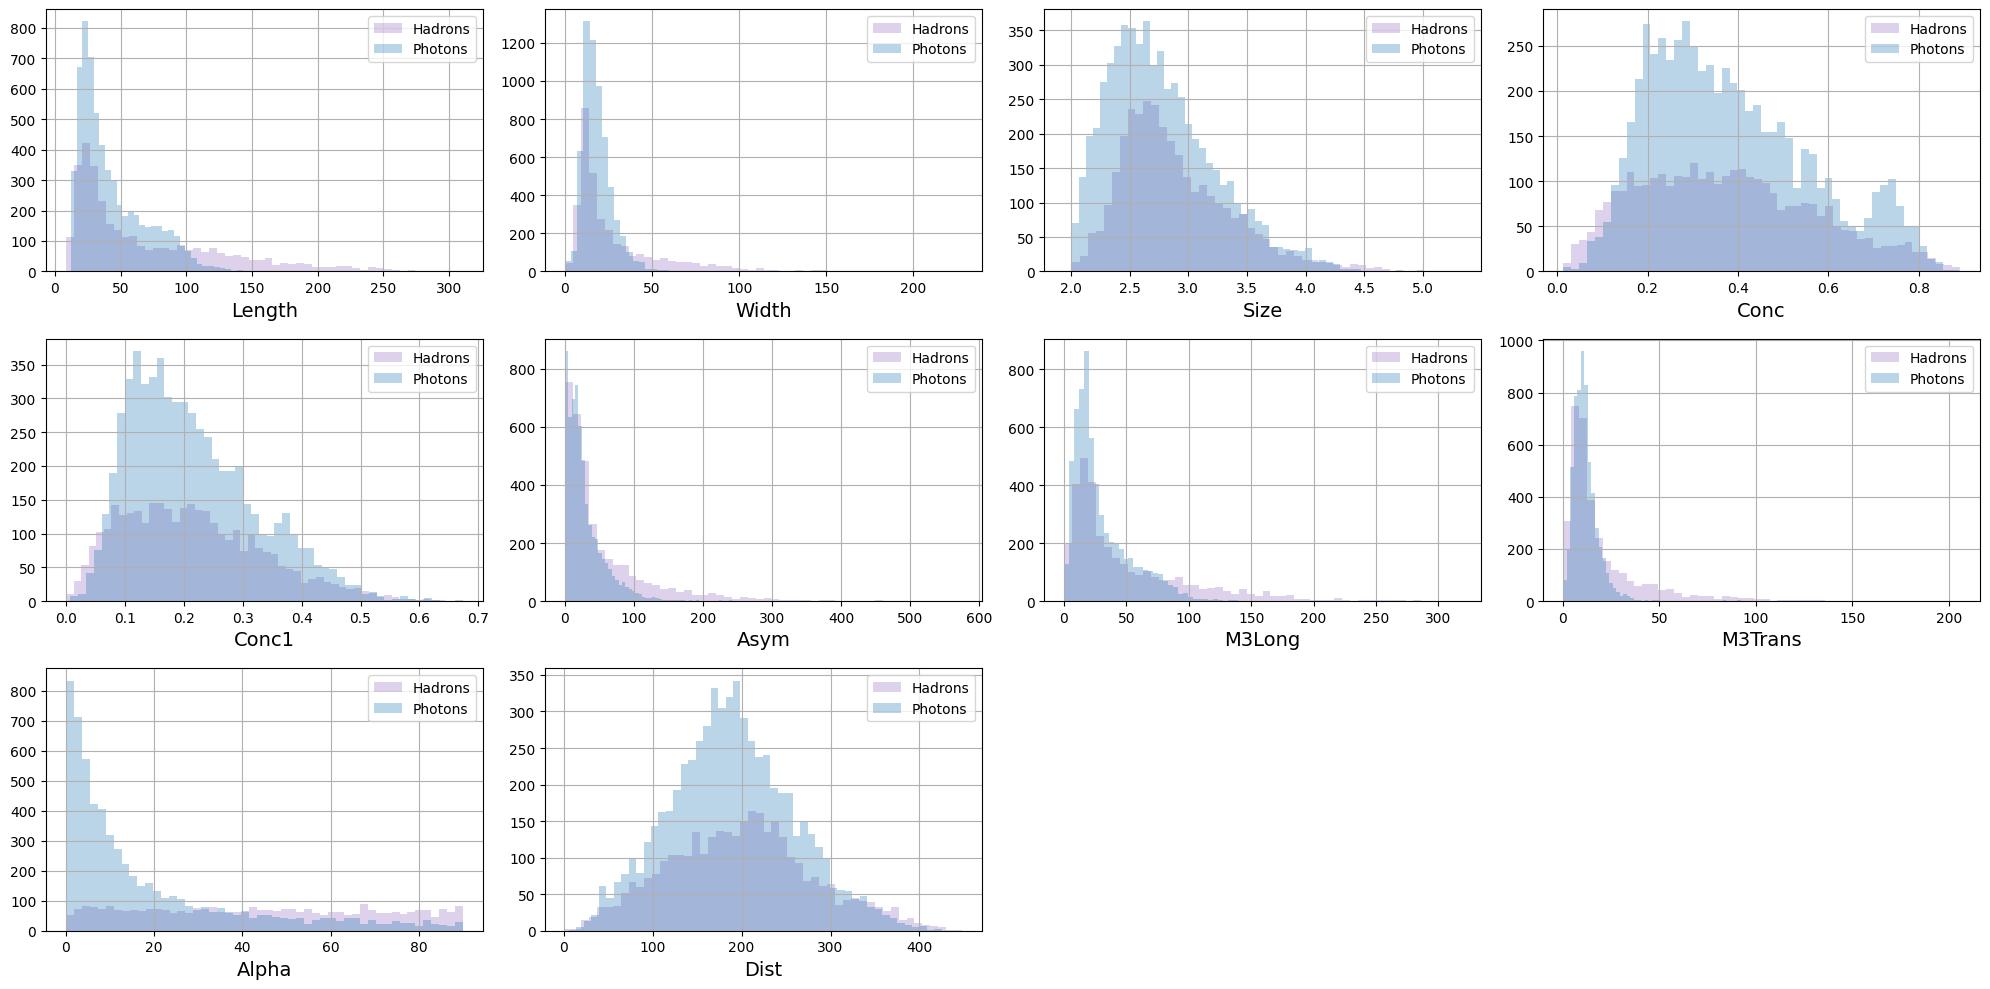

In [10]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

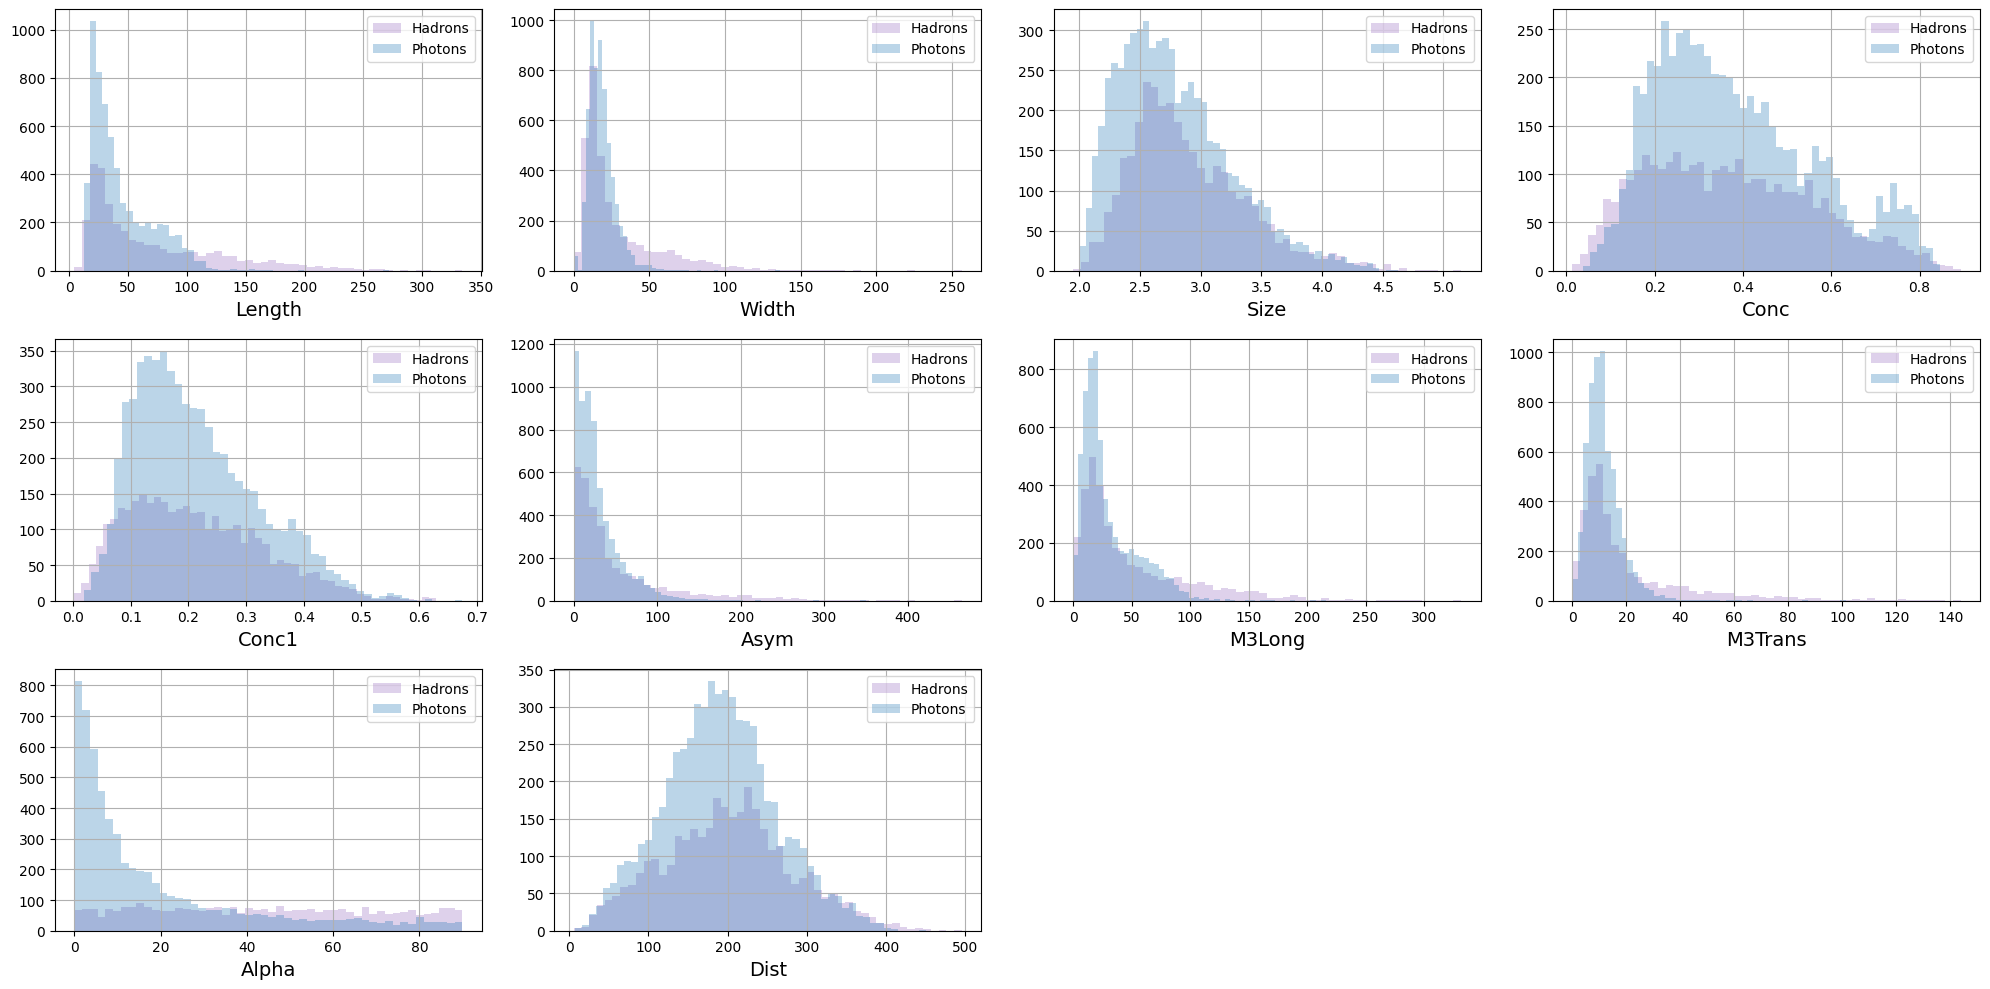

In [ ]:
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [11]:
from sklearn.preprocessing import QuantileTransformer

# Инициализация QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=11)

In [12]:
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)

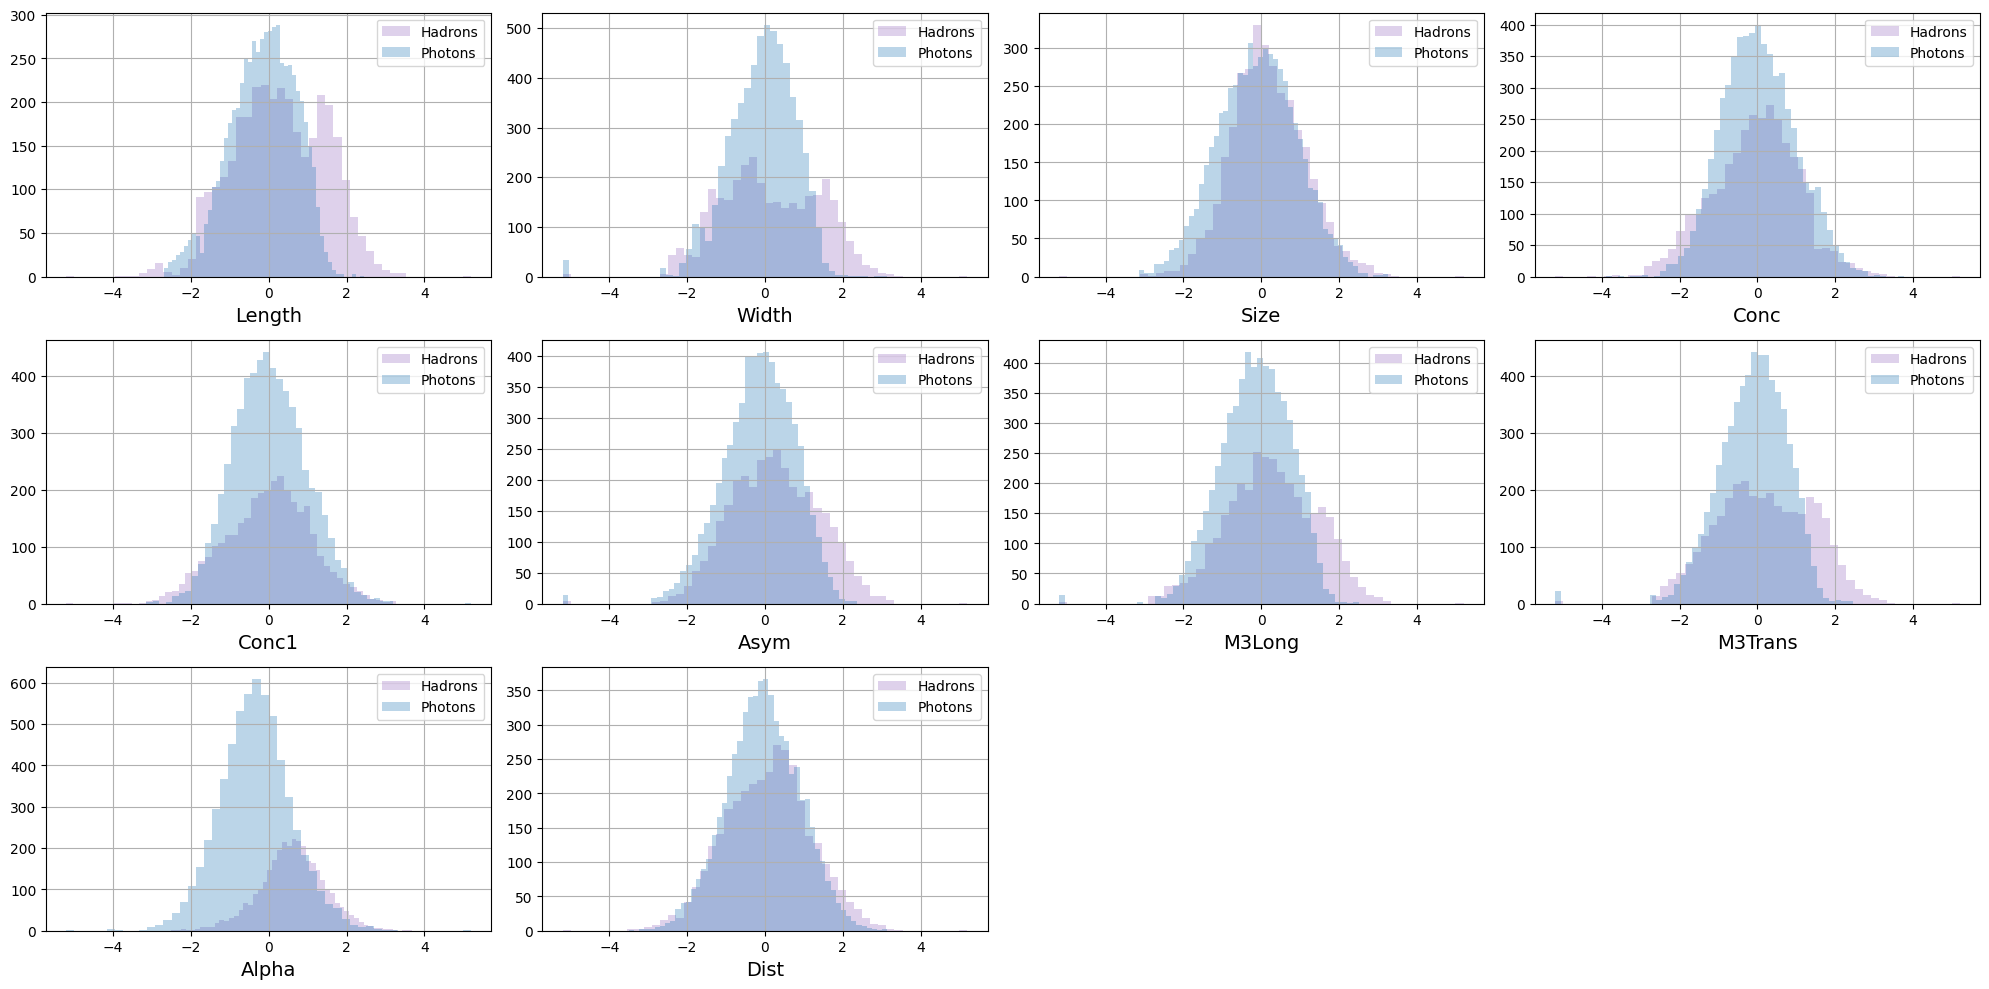

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

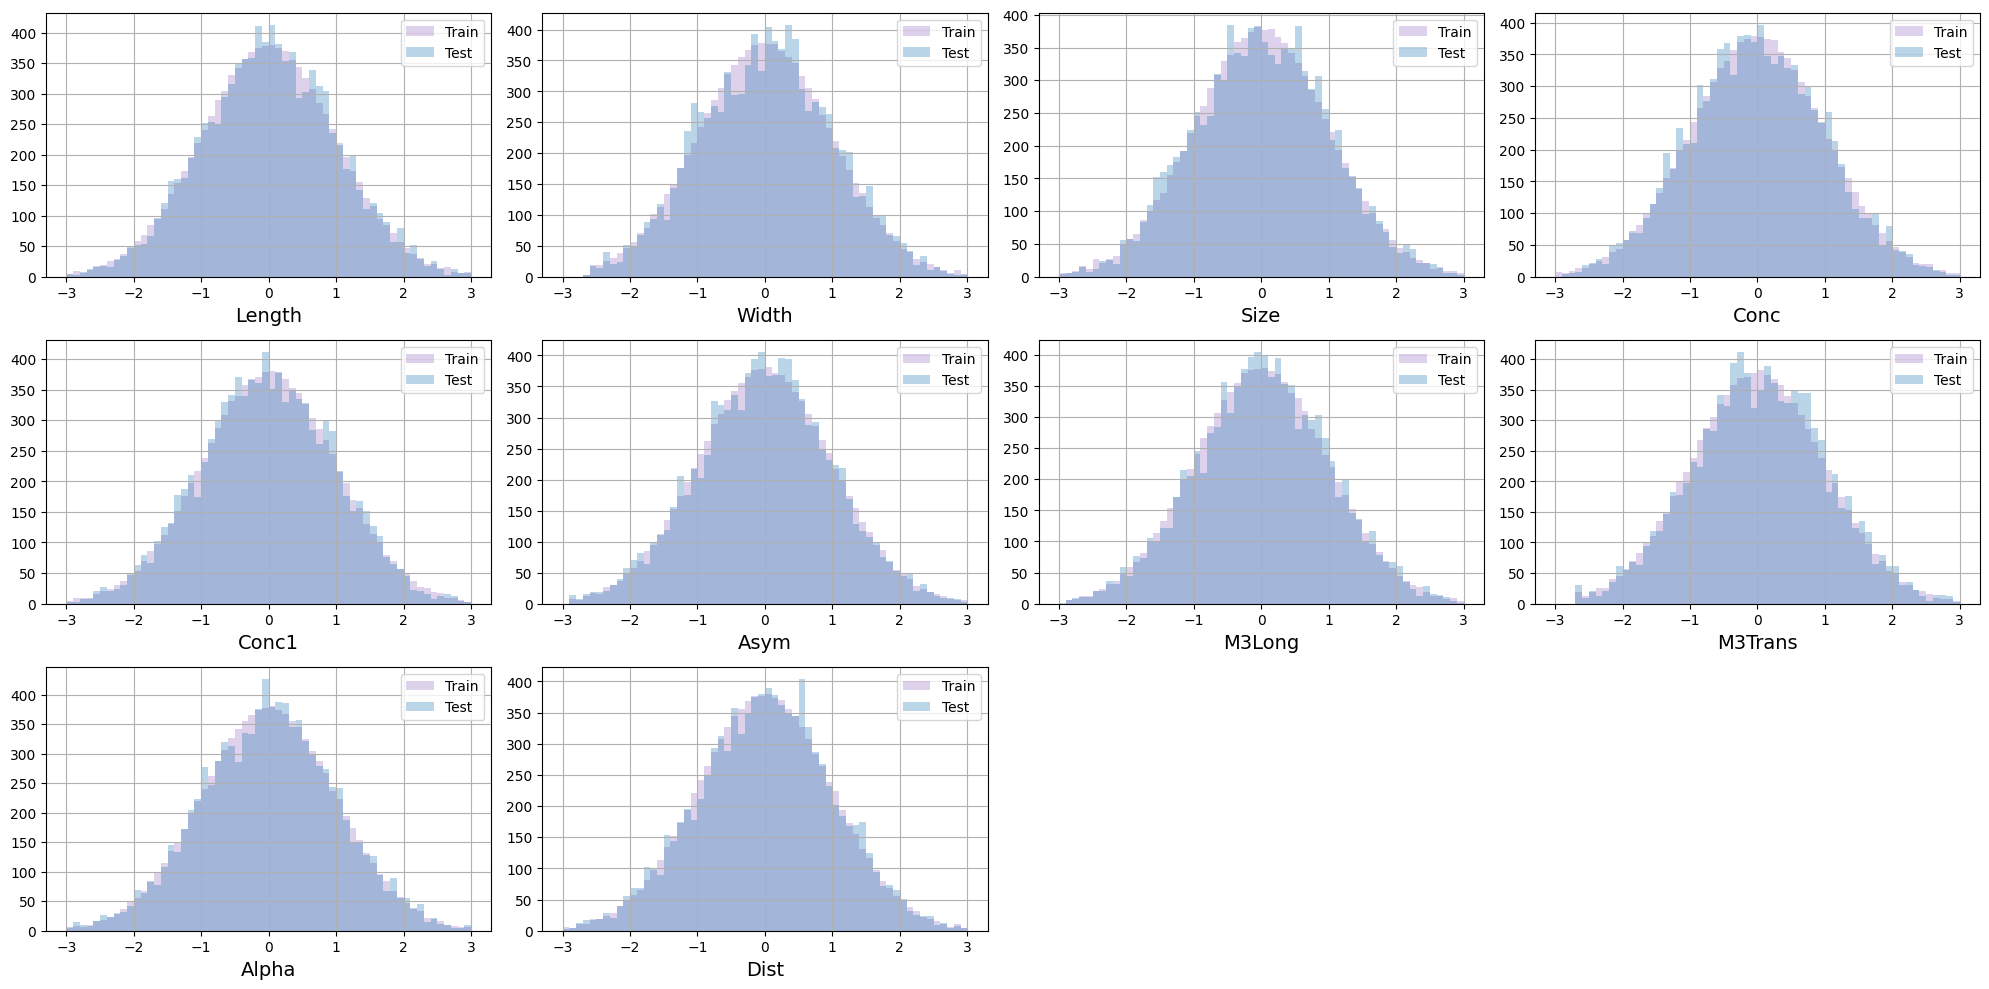

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [16]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [17]:
def generate(generator, y, latent_dim):
    # Генерация случайного шума
    z = torch.randn(len(y), latent_dim)

    generator.eval()

    # Генерация объектов с использованием генератора
    with torch.no_grad():
        X_fake_tensor = generator(z, y)

    # Переводим из PyTorch tensor в NumPy array
    X_fake_numpy = X_fake_tensor.numpy()

    return X_fake_numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Относительно функции активации в конце модели, обычно в дискриминаторе используется сигмоидная функция активации (например, nn.Sigmoid()), чтобы преобразовать выход в диапазон от 0 до 1. Это позволяет интерпретировать выход как вероятность принадлежности входного объекта к классу (настоящие данные или сгенерированные). Функция активации сигмоиды полезна в бинарной классификации, где требуется предсказать, принадлежит ли объект классу 1 или 0.



## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X_combined = np.vstack((X_real, X_fake))
    y_combined = np.vstack((np.ones_like(y_real), np.zeros_like(y_fake))).reshape(-1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, stratify=y_combined, test_size=0.25, shuffle=True, random_state=11
    )

    # Обучение модели линейной регрессии
    lr_model = LogisticRegression(random_state=11)
    lr_model.fit(X_train, y_train)

    # Обучение модели градиентного бустинга
    gb_model = GradientBoostingClassifier(random_state=11)
    gb_model.fit(X_train, y_train)

    # Предсказания на тестовой выборке
    lr_predictions = lr_model.predict(X_test)
    gb_predictions = gb_model.predict(X_test)

    # Расчет accuracy score
    lin_reg_score = accuracy_score(y_test, lr_predictions)
    boosting_score = accuracy_score(y_test, gb_predictions)

    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [31]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### TRAIN DISCRIMINATOR ###
                for _ in range(self.n_critic):
                    self.opt_disc.zero_grad()

                    z_noise = torch.randn(len(real_batch), self.latent_dim, device=DEVICE)
                    z_cond_batch = torch.randint(0, 2, (len(real_batch), 1), device=DEVICE)
                    fake = self.generator(z_noise, z_cond_batch)

                    loss_real = -torch.mean(self.discriminator(real_batch, cond_batch))
                    loss_fake = torch.mean(self.discriminator(fake.detach(), z_cond_batch))

                    loss_discriminator = loss_real + loss_fake

                    loss_discriminator.backward()
                    self.opt_disc.step()

                    # Clip discriminator weights
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                ### TRAIN GENERATOR ###
                self.opt_gen.zero_grad()

                z_noise = torch.randn(len(real_batch), self.latent_dim, device=DEVICE)
                z_cond_batch = torch.randint(0, 2, (len(real_batch), 1), device=DEVICE)
                fake = self.generator(z_noise, z_cond_batch)

                loss_generator = -torch.mean(self.discriminator(fake, z_cond_batch))

                loss_generator.backward()
                self.opt_gen.step()

            # Generate noise
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim), device=DEVICE)

            # Generate fake data
            X_fake = self.generator(Z_noise, y_cond)

            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            loss_epoch_numpy = loss_epoch.detach().cpu()
            self.loss_history.append(loss_epoch_numpy)

            # Create a sample of 1000 objects from X_train and 1000 generated objects
            random_indices = np.random.choice(len(X_real), size=1000, replace=False)

            X_real_sample = X_real[random_indices]
            y_cond_sample = y_cond[random_indices]

            Z_noise = torch.normal(0, 1, (1000, self.latent_dim), device=DEVICE)
            X_fake_sample = self.generator(Z_noise, y_cond_sample)

            print(f"LOSS EPOCH №{epoch}: {loss_epoch_numpy}")
            # Run the other_agent_score function
            other_agent_score(
                X_real_sample.detach().numpy(),
                y_cond_sample.detach().numpy(),
                X_fake_sample.detach().numpy(),
                y_cond_sample.detach().numpy())


        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [32]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

LOSS EPOCH №0: 0.00016677379608154297
Linear regression score: 0.554
Boosting score: 0.736
LOSS EPOCH №1: 3.123283386230469e-05
Linear regression score: 0.536
Boosting score: 0.708
LOSS EPOCH №2: 1.990795135498047e-05
Linear regression score: 0.518
Boosting score: 0.686
LOSS EPOCH №3: 1.1563301086425781e-05
Linear regression score: 0.552
Boosting score: 0.682
LOSS EPOCH №4: -3.0219554901123047e-05
Linear regression score: 0.54
Boosting score: 0.694
LOSS EPOCH №5: 5.4836273193359375e-06
Linear regression score: 0.536
Boosting score: 0.652
LOSS EPOCH №6: -2.7239322662353516e-05
Linear regression score: 0.542
Boosting score: 0.66
LOSS EPOCH №7: 3.0994415283203125e-05
Linear regression score: 0.638
Boosting score: 0.66
LOSS EPOCH №8: -3.972649574279785e-05
Linear regression score: 0.614
Boosting score: 0.668
LOSS EPOCH №9: -2.1457672119140625e-05
Linear regression score: 0.56
Boosting score: 0.684
LOSS EPOCH №10: -3.3736228942871094e-05
Linear regression score: 0.596
Boosting score: 0.688


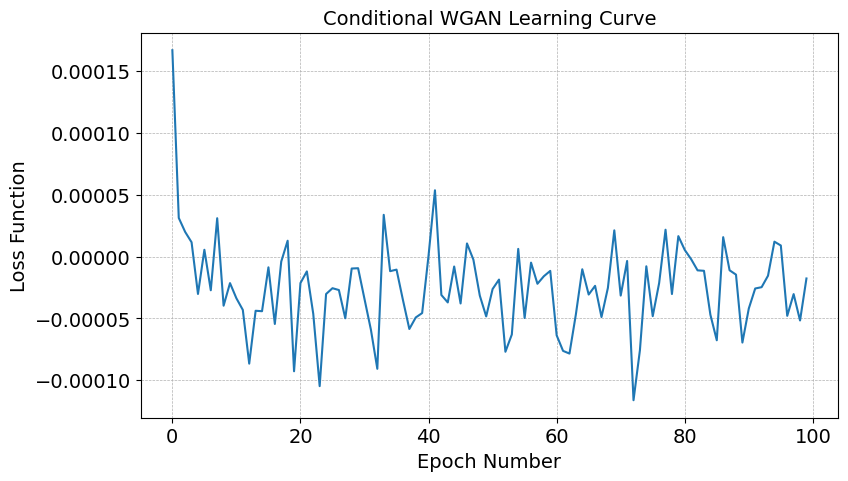

In [33]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [34]:
y_cond_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
y_cond_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)

In [35]:
X_train_inv = quantile_transformer.inverse_transform(X_train)

In [36]:
X_fake_train = quantile_transformer.inverse_transform(generate(fitter.generator, y_cond_train, latent_dim))

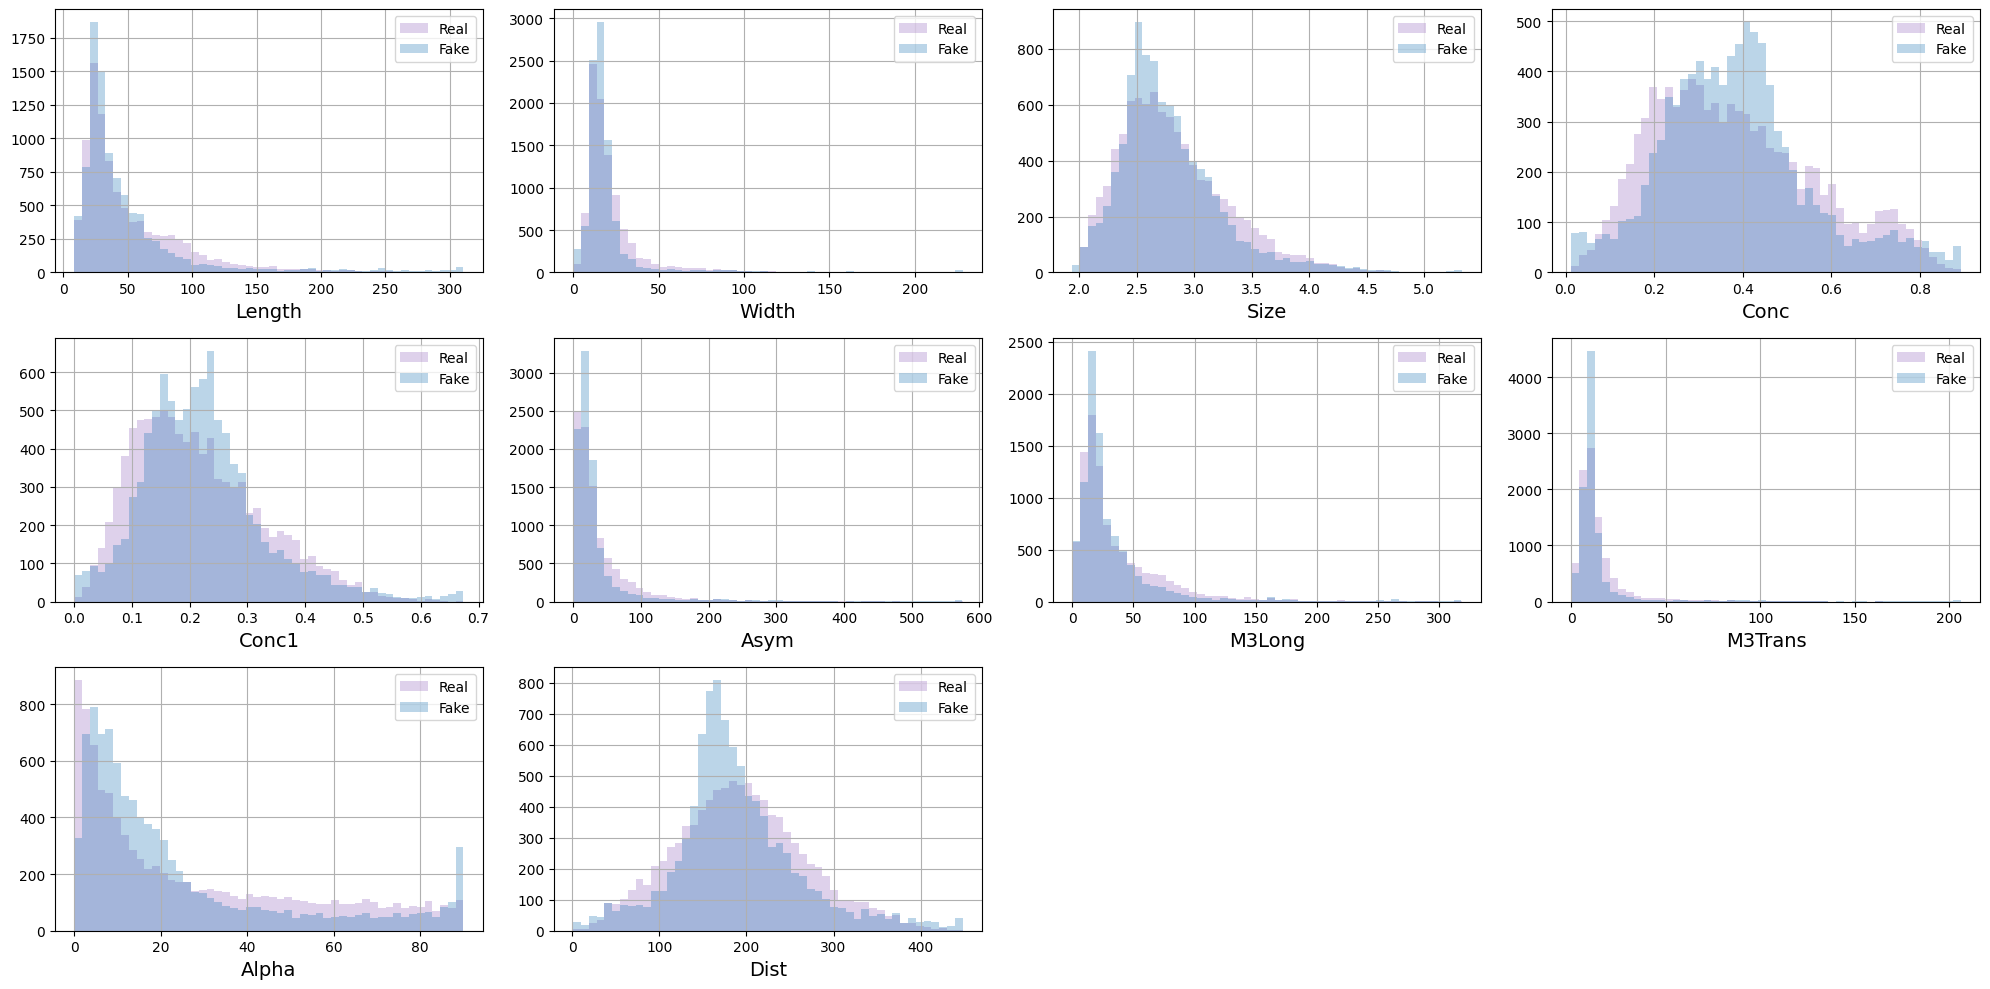

In [37]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [38]:
X_test_inv = quantile_transformer.inverse_transform(X_test)

In [39]:
X_fake_test = quantile_transformer.inverse_transform(generate(fitter.generator, y_cond_test, latent_dim))

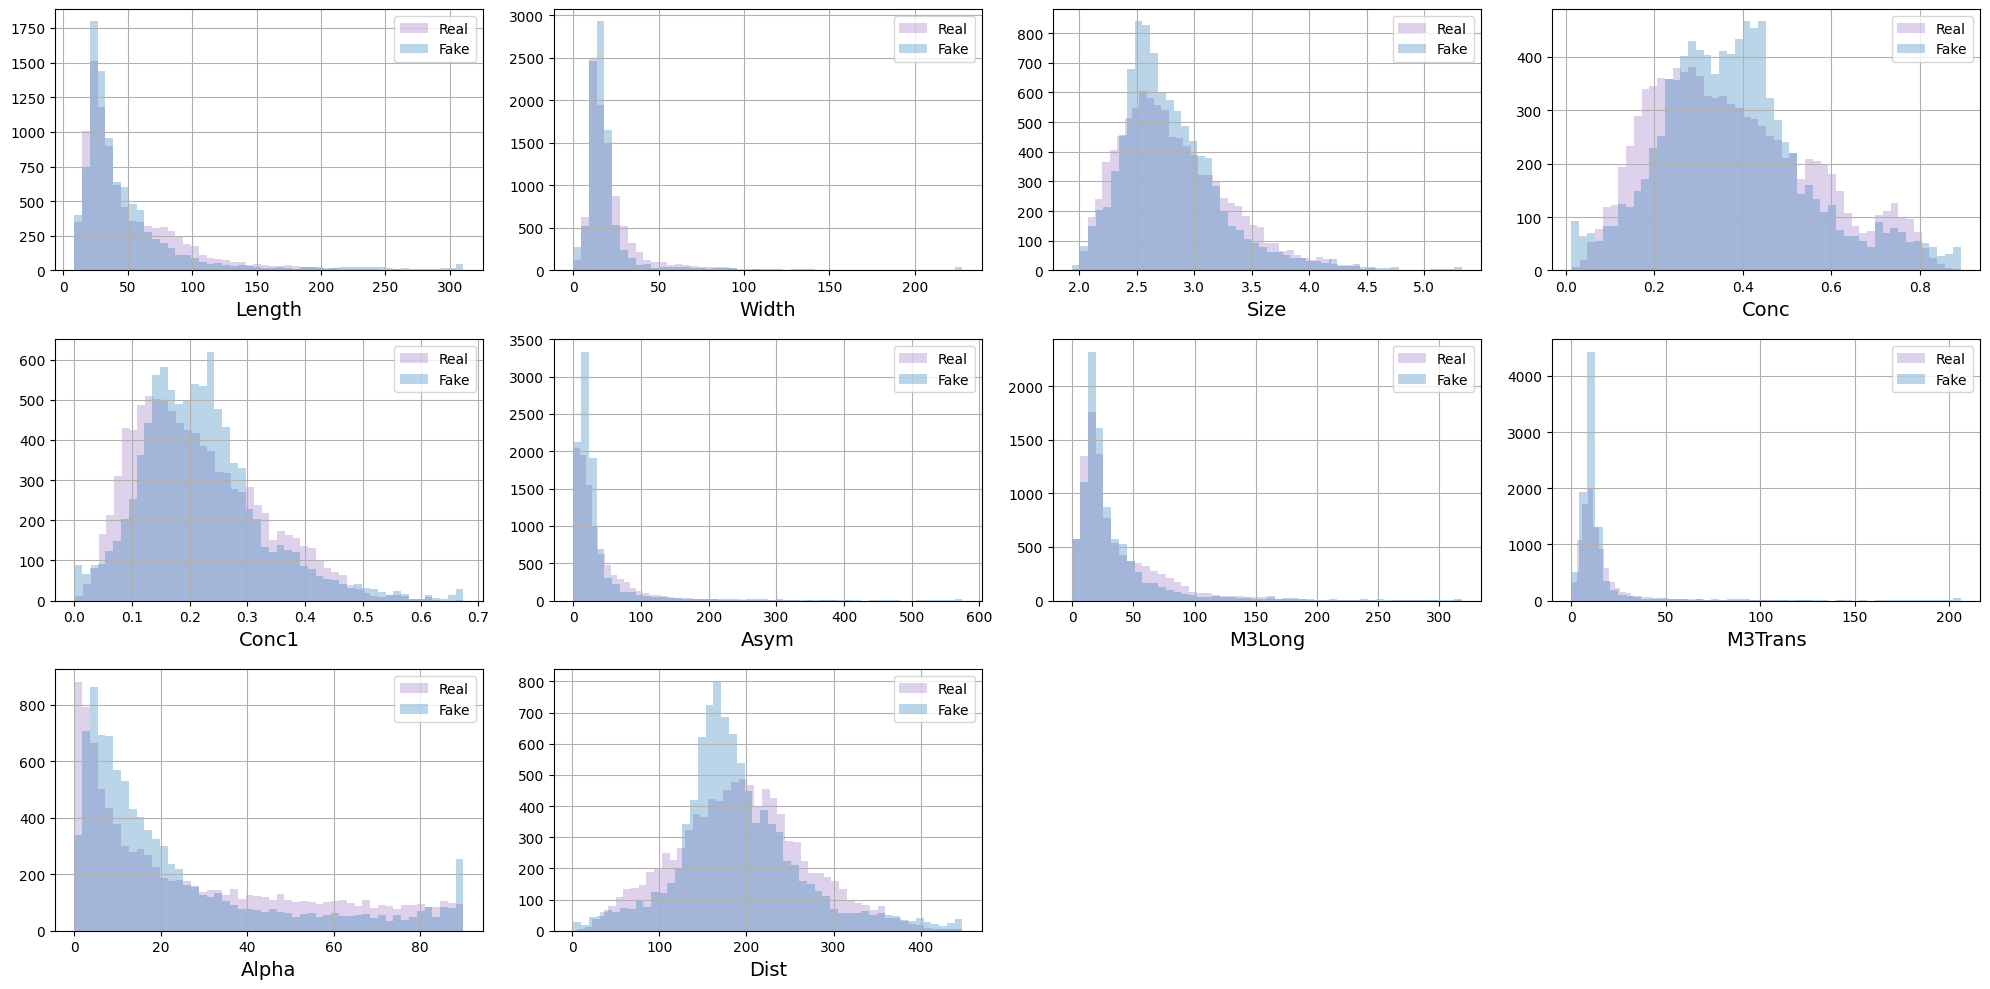

In [40]:
plot_hists(X_test_inv, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [41]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [43]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8265558972181588


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Значение ROC AUC составляет 0.7309, что означает, что классификатор имеет некоторую способность различать между реальными и фейковыми данными.

Если бы цель стояла в создании генеративной модели, которая создает данные, неотличимые от реальных, то мы хотели бы достичь ROC AUC близкого к 1, чтобы классификатор не смог бы различить между ними. Но у нас задача найти новые параметры для частиц, поэтому кажется, что значение ROC AUC в 0.73 является приемлемым для текущей задачи. Модель добилась некоторого сходства между реальными и сгенерированными данными.


# Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

In [47]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.5 MB/s eta 0:00:00


## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [45]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount

Добавим sсheduler, он пригодится вам при обучении модели

In [48]:
from diffusers import DDPMScheduler

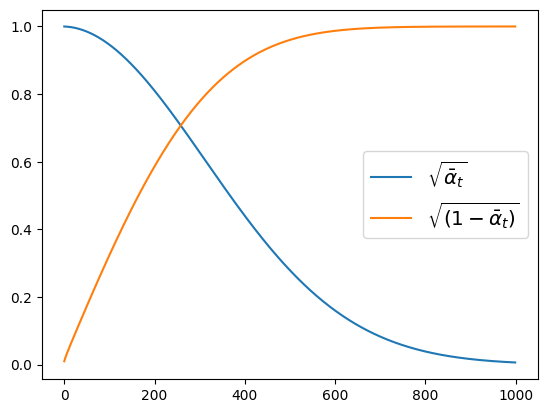

In [49]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [53]:
 for i in range(noise_scheduler.num_train_timesteps):
  current_noise_level = noise_scheduler.get_level_or_attribute(i)
  print(current_noise_level)


AttributeError: ignored

In [50]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
            nn.Sigmoid()
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():
        batch_size = y.size(0)

        # Генерируем случайный шум
        z = torch.randn((batch_size, latent_dim))

        # Начинаем генерацию с нулевого уровня шума
        current_noise_level = 0.0

        # Прогоняем через модель несколько раз с увеличивающимся уровнем шума
        for i in range(scheduler.num_steps):
            current_noise_level = scheduler.get_level(i)

            # Генерируем данные с использованием диффузионной модели
            X_fake = model(z, y)

            # Применяем текущий уровень шума
            X_fake = corrupt(X_fake, torch.tensor(current_noise_level).view(-1, 1))

        # Возвращаем сгенерированные данные в виде numpy
        return X_fake.numpy()

# Пример использования:
# Предположим, что model - ваша обученная модель, y - метка класса, latent_dim - размерность шумового вектора,
# а scheduler - объект, управляющий уровнем шума по мере генерации.
# generated_data = generate_with_diffusion(model, y, latent_dim, scheduler)


## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        loss_fn = nn.MSELoss()

        # Fit
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                ...

                loss_epoch += ...

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            ...
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

# Бонусная часть (3 балла)

## Условные вариационные автокодировщики


<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/cvae.svg?raw=1" width="600"></center>

Теперь, решим эту же задачу используя условный автокодировщик (CVAE). Пользуясь вашим семинаром по теме вариационных автокодировщиков выполните следующие задания.

### Задание 15 (0.5 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой для mu; Выходной слой для log_sigma;

Подсказка: используйте функцию `nn.Sequential()`.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = ...

        self.mu = ...
        self.log_sigma = ...
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma

### Задание 16 (0.5 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Подсказка: используйте функцию `nn.Sequential()`.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = ...
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

### Задание 17 (0.5 балл)

Реализуйте класс для обучения вариационного автокодировщика.


In [ ]:
class VAEFitter(object):

    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)


    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return KL*self.KL_weight + recon_loss


    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        loss = ...
        ### THE END OF YOUR CODE ###

        return loss


    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

### Обучение
Обучим модель на данных.

In [ ]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()



Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    X_fake = ...
    ### THE END OF YOUR CODE ###
    return X_fake # numpy


По аналогии с прошлым экспериментом сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью и диффузией?

# Нормализационные потоки

## Задание 18 (1.5 балла)

Для CVAE получили ROC AUC около 0.7 (меньше лучше). Таким образом видим, что в данной задаче обе модели ведут себя схожим образом. Но может их можно как-то улучшить? Попробуйте обучить любой вид нормализационного потока для решения этой задачи. Сравните результаты с другими моделями, рассчитайте метрики, как в предыдущих заданиях

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/mem1.jpg?raw=1" width="500"></center>

<center><img src="https://github.com/hse-mlds/deep-learning/blob/main/HWs/HW2_GenModels/img/mem2.jpg?raw=1" width="500"></center>

# Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!